In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [6]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [9]:
train_data = pd.read_csv('/train_data.csv', index_col='Claim Identifier')


FileNotFoundError: [Errno 2] No such file or directory: 'Data/train_data.csv'

In [7]:
#drop target variable
df = train_data.drop(columns='Claim Injury Type')

NameError: name 'train_data' is not defined

In [8]:
df.head(15)

NameError: name 'df' is not defined

In [7]:
df.tail()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
327160035,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6165075,2022-12-13,72.0,N,2022-12-31,N,0.0,1950.0,2022-12-31,NaN,TECHNOLOGY INSURANCE CO. INC.,1A. PRIVATE,SULLIVAN,N,BINGHAMTON,NaN,F,NaN,48.0,TRANSPORTATION AND WAREHOUSING,I,NaN,25.0,FROM DIFFERENT LEVEL (ELEVATION),90.0,MULTIPLE PHYSICAL INJURIES ONLY,-9.0,MULTIPLE,12779,0.0,Not Work Related,3.0
249875936,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120584215,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
818961390,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.shape

(593471, 31)

Surprise we have a whole fucking lot of features with Dtype object

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 593471 entries, 5393875 to 818961390
Data columns (total 31 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  County of Injury      

## Percentage of missing values per feature
OIICS Nature of Injury Description has no values

_`IME-4 Count`_, _`First Hearing Date`_ and _`C-3 Date`_ have >50% of entries missing ( 77.6%, 74.5 and 68.4%, respectively)

In [10]:
df.isnull().sum()/df.shape[0]*100

Accident Date                           3.898084
Age at Injury                           3.276487
Alternative Dispute Resolution          3.276487
Assembly Date                           0.000000
Attorney/Representative                 3.276487
Average Weekly Wage                     8.104187
Birth Year                              8.176137
C-2 Date                                5.729850
C-3 Date                               68.449174
Carrier Name                            3.276487
Carrier Type                            3.276487
County of Injury                        3.276487
COVID-19 Indicator                      3.276487
District Name                           3.276487
First Hearing Date                     74.590502
Gender                                  3.276487
IME-4 Count                            77.622664
Industry Code                           4.954412
Industry Code Description               4.954412
Medical Fee Region                      3.276487
OIICS Nature of Inju

In [11]:
#duplicated values
df.duplicated().sum()


18351

Variables like _`Attorney/Representative`_ and maybe _`COVID-19 Indicator`_ can be changed to Boolean or some other form of data enconding

In [12]:
df.describe(include='O')
  

,Accident Date,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Description,WCIO Nature of Injury Description,WCIO Part Of Body Description,Zip Code,WCB Decision
count,570337,574026,593471,574026,559466,187245,574026,574026,574026,574026,574026,150798,574026,564068,574026,558386,558369,556944,545389,574026
unique,5539,3,1096,2,2475,1648,2046,8,63,2,8,1094,4,20,5,74,56,54,10060,1
top,2020-03-01,N,2020-03-06,N,2021-05-11,2021-04-21,STATE INSURANCE FUND,1A. PRIVATE,SUFFOLK,N,NYC,2022-04-15,M,HEALTH CARE AND SOCIAL ASSISTANCE,IV,LIFTING,STRAIN OR TEAR,LOWER BACK AREA,11236,Not Work Related
freq,1245,571412,1422,392291,1847,350,111144,285368,60430,546505,270779,440,335218,114339,265981,46610,153373,51862,3302,574026


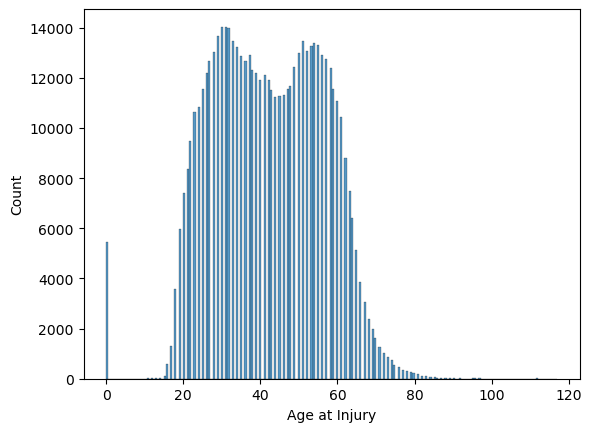

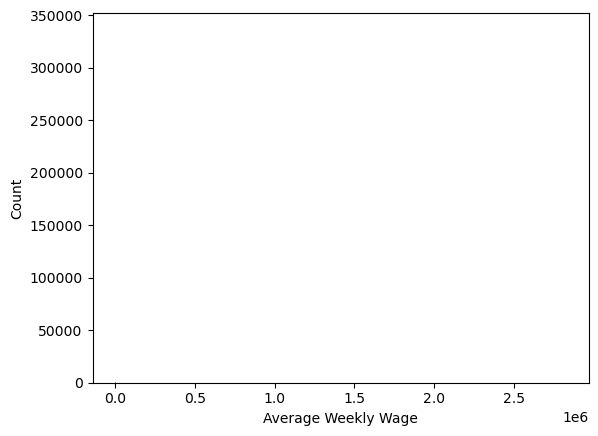

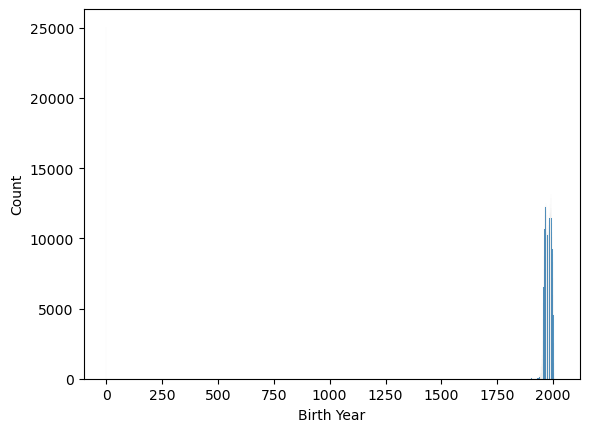

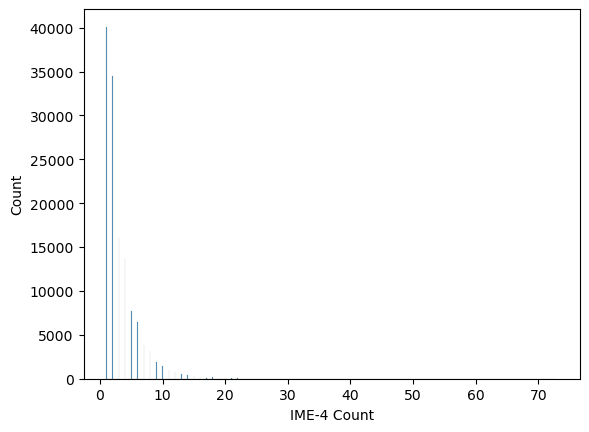

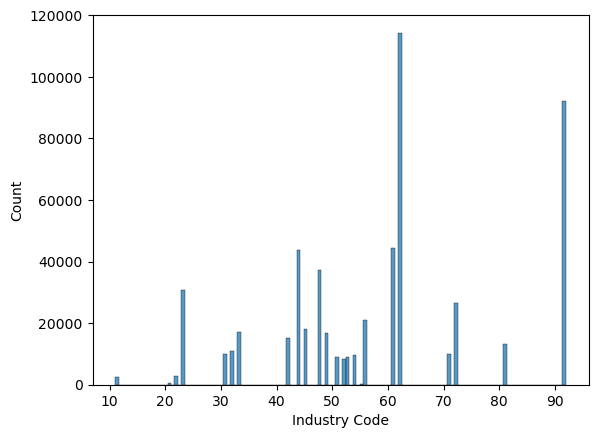

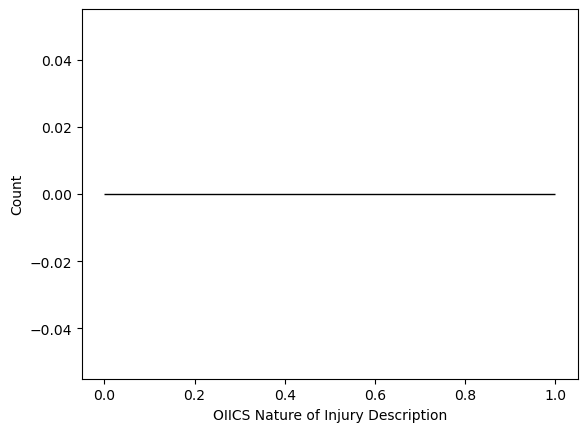

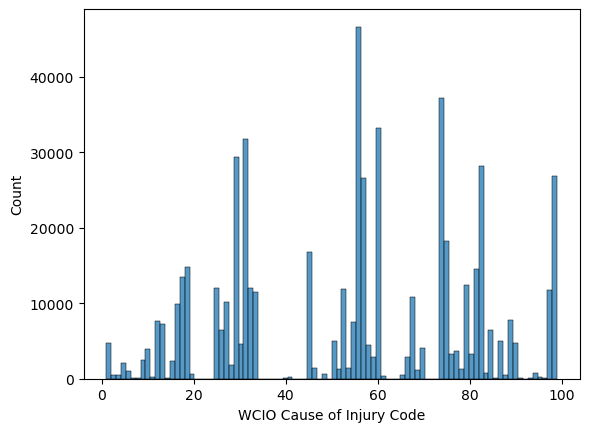

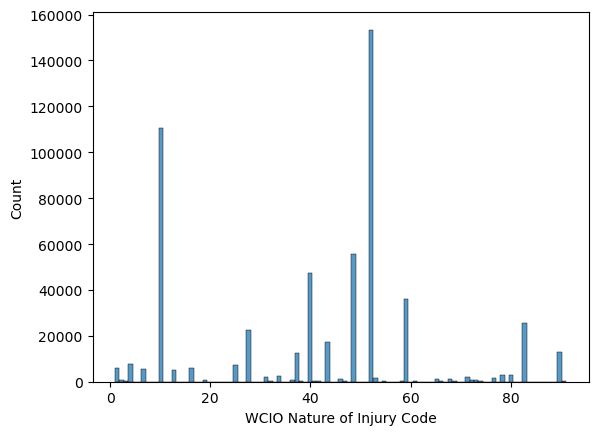

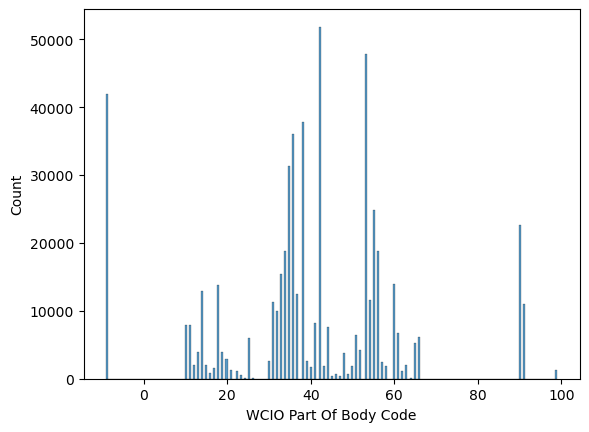

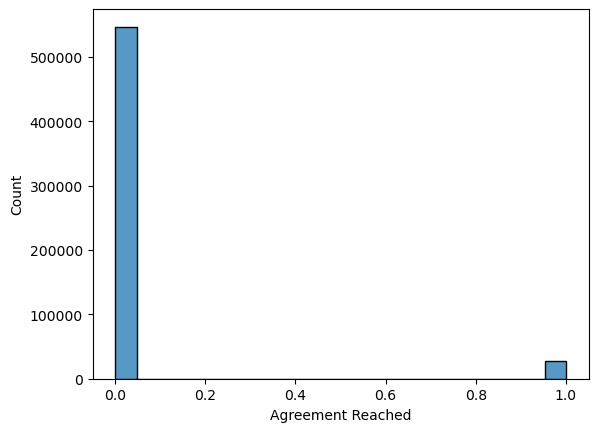

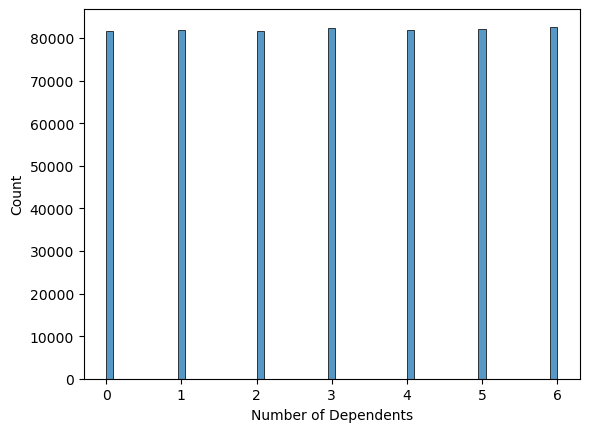

In [13]:
for i in df.select_dtypes(include='number').columns:
    sns.histplot(data=df, x=i)
    plt.show()